## Gait Video Study 
### Traditional ML algorithms on task+subject generalization together frameworks, namely a) train on some subjects in W-> test on separate set of subjects in WT and b) train on some subjects in VBW-> test on separate set of subjects in VBWT to classify HOA/MS/PD strides and subjects 
#### Remember to add the original count of frames in a single stride (before down sampling via smoothing) for each stride as an additional artificial feature to add information about speed of the subject to the model

1. Save the optimal hyperparameters, confusion matrices and ROC curves for each algorithm.
2. Make sure to not use x, y, z, confidence = 0, 0, 0, 0 as points for the model since they are simply missing values and not data points, so make sure to treat them before inputting to model 
3. Make sure to normalize (z-score normalization) the features before we feed them to the model.
4. We use the summary statistics as range, CoV and asymmetry between the right and left limbs as the features to input to the traditional models requiring fixed size 1D input for each training/testing set sample.
5. For implementation of task+subject generalization together framework 1: i.e. train on some subjects in W and test on remaining separate set of subjects in WT,  since we have 32 subjects in training/W and 26 subjects in testing/WT and 25 subjects that are common in both W and WT. We always keep the (32-25) = 7 subjects only available in W in training and always keep (26-25) = 1 subject only available in WT in testing along with cross validation folds created for training and testing sets from the 25 common subjects in both. So, basically, for 5 fold cross validation on 25 common subjects, we train on 20 + 7 subjects and test on 5+1 subjects where these 20 and 5 subjects keep on changing with each fold, but the 7 and 1 subjects remain the same.
6. We use stratified group 5 fold cross validation.

In [1]:
from importlib import reload
from ml_utils.imports import *

from ml_utils import cross_gen_traditionalML
reload(cross_gen_traditionalML)
from ml_utils.cross_gen_traditionalML import extract_train_test_common_PIDs, compute_train_test_indices_split
from ml_utils.cross_gen_traditionalML import models, design, plot_ROC, run_ml_models

In [2]:
path = 'C:\\Users\\Rachneet Kaur\\Box\\Gait Video Project\\GaitVideoData\\video\\'
data_path = path+'traditional_methods_dataframe.csv'
results_path = 'C:\\Users\\Rachneet Kaur\\Box\Gait Video Project\\MLresults\\'

data = pd.read_csv(data_path, index_col= 0)
display(data.head
        
#Whether to save the results (confusion matrices and RoC plots) or not 
save_results = True 

,key,cohort,trial,scenario,video,PID,stride_number,frame_count,label,right hip-x-CoV,right hip-y-CoV,right hip-z-CoV,right knee-x-CoV,right knee-y-CoV,right knee-z-CoV,right ankle-x-CoV,right ankle-y-CoV,right ankle-z-CoV,left hip-x-CoV,left hip-y-CoV,left hip-z-CoV,left knee-x-CoV,left knee-y-CoV,left knee-z-CoV,left ankle-x-CoV,left ankle-y-CoV,left ankle-z-CoV,left toe 1-x-CoV,left toe 1-y-CoV,left toe 1-z-CoV,left toe 2-x-CoV,left toe 2-y-CoV,left toe 2-z-CoV,left heel-x-CoV,left heel-y-CoV,left heel-z-CoV,right toe 1-x-CoV,right toe 1-y-CoV,right toe 1-z-CoV,right toe 2-x-CoV,right toe 2-y-CoV,right toe 2-z-CoV,right heel-x-CoV,right heel-y-CoV,right heel-z-CoV,right hip-x-range,right hip-y-range,right hip-z-range,right knee-x-range,right knee-y-range,right knee-z-range,right ankle-x-range,right ankle-y-range,right ankle-z-range,left hip-x-range,left hip-y-range,left hip-z-range,left knee-x-range,left knee-y-range,left knee-z-range,left ankle-x-range,left ankle-y-range,left ankle-z-range,left toe 1-x-range,left toe 1-y-range,left toe 1-z-range,left toe 2-x-range,left toe 2-y-range,left toe 2-z-range,left heel-x-range,left heel-y-range,left heel-z-range,right toe 1-x-range,right toe 1-y-range,right toe 1-z-range,right toe 2-x-range,right toe 2-y-range,right toe 2-z-range,right heel-x-range,right heel-y-range,right heel-z-range,hip-x-asymmetry,hip-y-asymmetry,hip-z-asymmetry,knee-x-asymmetry,knee-y-asymmetry,knee-z-asymmetry,ankle-x-asymmetry,ankle-y-asymmetry,ankle-z-asymmetry,heel-x-asymmetry,heel-y-asymmetry,heel-z-asymmetry,toe 1-x-asymmetry,toe 1-y-asymmetry,toe 1-z-asymmetry,toe 2-x-asymmetry,toe 2-y-asymmetry,toe 2-z-asymmetry
0,GVS_212_T_T1_1,HOA,BW,SLWT,GVS_212_T_T1,212,1,46,0,0.046077,0.034890,0.004297,0.095552,0.023449,0.034296,0.165017,0.140369,0.442588,0.233172,0.038750,0.004312,0.145337,0.026852,0.013372,0.154423,0.127961,0.203480,0.190814,0.107154,0.827100,0.231699,0.119630,0.787178,0.162847,0.100844,0.468157,0.157325,0.064312,1.198913,0.141141,0.065652,1.200924,0.143717,0.122637,0.585683,7.212309,20.620270,1.991843,9.964181,13.444621,9.038304,21.594528,76.063625,31.074113,13.329466,21.961515,1.991843,9.858765,14.225126,3.894683,14.372807,55.463843,16.647940,16.425025,65.548873,21.766010,22.508497,60.997153,22.014344,16.300582,58.040586,23.324031,15.922455,34.098386,13.121999,17.271819,29.814971,13.798620,12.893203,68.703027,22.493666,6.117157,1.341245,0.0,0.105416,0.780506,5.143621,7.221721,20.599782,14.426173,3.407379,10.662441,0.830365,0.502570,31.450487,8.644012,5.236678,31.182183,8.215725
1,GVS_212_T_T1_2,HOA,BW,SLWT,GVS_212_T_T1,212,2,39,0,0.021528,0.025036,0.003412,0.056296,0.023447,0.033758,0.125686,0.098426,0.302237,0.155463,0.025771,0.003424,0.083200,0.020327,0.030703,0.091782,0.081066,0.255452,0.091156,0.051776,0.832680,0.117199,0.056504,0.898666,0.091052,0.075414,0.299964,0.088011,0.123339,0.673944,0.115438,0.125203,0.673359,0.128054,0.111051,0.422984,3.414412,13.464709,1.247746,5.697790,12.715020,9.394594,12.082187,37.163109,15.383479,4.778190,11.777324,1.247746,4.225919,8.137347,9.608517,8.598281,30.531277,14.022632,8.250031,24.865688,15.579627,9.085920,36.896358,23.869958,8.331596,33.077938,14.108215,9.275678,53.132088,18.250708,15.764214,51.955183,18.966380,13.486903,44.441744,18.441991,1.363778,1.687386,0.0,1.471870,4.577674,0.213923,3.483906,6.631832,1.360847,5.155307,11.363806,4.333776,1.025647,28.266400,2.671081,6.678294,15.058825,4.903579
2,GVS_212_T_T1_3,HOA,BW,SLWT,GVS_212_T_T1,212,3,56,0,0.034394,0.021444,0.000000,0.093182,0.027562,0.039129,0.219685,0.079954,0.389772,0.123618,0.034152,0.000000,0.137763,0.040302,0.029402,0.184402,0.078119,0.365340,0.180999,0.070197,1.049169,0.232832,0.090458,1.039036,0.184111,0.099589,0.444482,0.187098,0.068151,1.359888,0.215648,0.071937,1.176031,0.240568,0.087482,0.516042,3.851961,10.182146,0.000000,9.139212,13.880261,12.388595,19.428682,47.954633,23.423173,2.608223,13.066705,0.000000,7.518423,16.418774,8.928109,14.149397,45.568276,22.082152,15.827351,

### main()

#### Task+subject generalization together framework 1: train on walking (W) and test on walking while talking (WT) to classify HOA/MS/PD strides and subjects 

In [3]:
#We are training on some subjects of trial W and testing on separate remaining subjects of trial WT
train_framework = 'W'
test_framework = 'WT'

#Extracting the list of PIDs/subjects that are only included in the training set, only included in the testing set 
#and common PIDs in both training and testing sets 
train_pids, test_pids, common_pids = extract_train_test_common_PIDs(data, train_framework, test_framework)
design()


Original number of subjects in training task W are: 32
Original number of subjects in testing task WT are: 26
Common number of subjects across train and test frameworks:  25
Common subjects across train and test frameworks:  [404, 405, 406, 407, 408, 409, 410, 411, 310, 311, 313, 314, 318, 320, 321, 322, 323, 212, 213, 214, 215, 216, 217, 218, 219]
Number of subjects only in training framework:  7
Subjects only in training framework:  [102, 112, 113, 115, 312, 123, 124]
Number of subjects only in test framework:  1
Subjects only in test framework:  [403]
******************************************


In [4]:
#Trial W for training 
trialW = data[data['scenario']==train_framework] #Full trial W with all 32 subjects 
#Trial WT for testing 
trialWT = data[data['scenario']==test_framework] #Full trial WT with all 26 subjects 

#Full training data stats 
print ('Number of subjects in trial W in each cohort:\n', trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete training set: ', len(trialW))
print ('HOA, MS and PD strides in complete training set:\n', trialW['cohort'].value_counts())
design()

#Full testing data stats 
print ('Number of subjects in trial WT in each cohort:\n', trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete testing set: ', len(trialWT))
print ('HOA, MS and PD strides in complete testing set:\n', trialWT['cohort'].value_counts())
design()

#Training only data with strides from W
train_only_trialW = trialW[trialW.PID.isin(train_pids)] #subset of trial W with subjects only present in trial W but not in trial WT
print ('Number of subjects only in trial W in each cohort:\n', train_only_trialW.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial W: ', len(train_only_trialW))
print ('HOA, MS and PD strides in of subjects only in trial W :\n', train_only_trialW['cohort'].value_counts())
design()

#Testing only data with strides from WT
test_only_trialWT = trialWT[trialWT.PID.isin(test_pids)] #subset of trial WT with subjects only present in trial WT but not in trial W
print ('Number of subjects only in trial WT in each cohort:\n', test_only_trialWT.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial WT: ', len(test_only_trialWT))
print ('HOA, MS and PD strides in of subjects only in trial WT :\n', test_only_trialWT['cohort'].value_counts())
design()

#Training data with strides from W for common PIDs in trials W and WT
train_trialW_commonPID = trialW[trialW.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', train_trialW_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial W in each cohort of subjects common to trials W and WT: ', len(train_trialW_commonPID))
print ('HOA, MS and PD strides in trial W of subjects common to trials W and WT:\n', train_trialW_commonPID['cohort'].value_counts())
design()

#Testing data with strides from WT for common PIDs in trials W and WT
test_trialWT_commonPID = trialWT[trialWT.PID.isin(common_pids)] #subset of trial W with common subjects in trial W and WT
print ('Number of subjects common to trials W and WT in each cohort:\n', test_trialWT_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial WT in each cohort of subjects common to trials W and WT: ', len(test_trialWT_commonPID))
print ('HOA, MS and PD strides in trial WT of subjects common to trials W and WT:\n', test_trialWT_commonPID['cohort'].value_counts())
design()

Number of subjects in trial W in each cohort:
 HOA    14
MS     10
PD      8
Name: cohort, dtype: int64
Strides in complete training set:  1651
HOA, MS and PD strides in complete training set:
 HOA    809
PD     453
MS     389
Name: cohort, dtype: int64
******************************************
Number of subjects in trial WT in each cohort:
 MS     9
PD     9
HOA    8
Name: cohort, dtype: int64
Strides in complete testing set:  1176
HOA, MS and PD strides in complete testing set:
 PD     493
HOA    351
MS     332
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial W in each cohort:
 HOA    6
MS     1
Name: cohort, dtype: int64
Strides of subjects only in trial W:  523
HOA, MS and PD strides in of subjects only in trial W :
 HOA    475
MS      48
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial WT in each cohort:
 PD    1
Name: cohort, dtype: int64
Strides of subjects only in trial 

In [5]:
cols_to_drop = ['key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label', 'PID']
X_train_common = train_trialW_commonPID.drop(cols_to_drop, axis = 1)
Y_train_common = train_trialW_commonPID[['PID', 'label']]

train_test_concatenated = pd.concat([trialW, trialWT], axis = 0).reset_index().drop('index', axis = 1)

#Shuffling the concatenated data
train_test_concatenated = shuffle(train_test_concatenated, random_state = 0)

#Computing the X (91 features), Y (PID, label) for the models 
X_full = train_test_concatenated.drop(cols_to_drop, axis=1)
Y_full = train_test_concatenated[['PID', 'label']]
print (X_full.shape, Y_full.shape) #1176+1651

#Computing the training and test set indices for the CV folds 
train_indices, test_indices = compute_train_test_indices_split(train_test_concatenated, X_train_common, Y_train_common, \
                                                               train_pids, test_pids, train_framework, test_framework)
framework = 'task_and_subject_WtoWT' #Defining the task generalization framework of interest

(2827, 91) (2827, 2)


random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 25, 'randomforestclassifier__max_features': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 50}
Stride-based model performance (mean):  [0.44338555325348306, 0.46081924253848916, 0.459340752740092, 0.42055638243253657, 0.6202694201448139]
Stride-based model performance (standard deviation):  [0.11304285064874212, 0.09355379699208372, 0.11816840985798467, 0.10244601934726424, 0.12573434872152833]
Person-based model performance (mean):  [0.45, 0.4666666666666666, 0.4333333333333333, 0.418095238095238, 0.6444444444444445]
Person-based model performance (standard deviation):  [0.1097306535409801, 0.15555555555555553, 0.13788526273323173, 0.1204827779113788, 0.1691025695024936]


<Figure size 432x288 with 0 Axes>

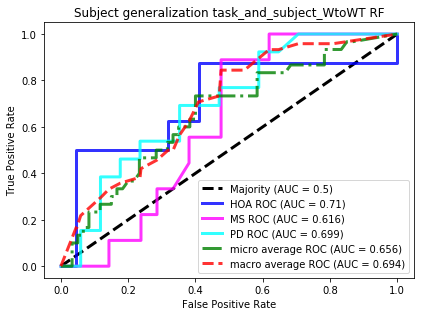

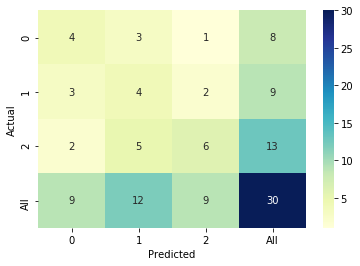

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1, 'adaboostclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.42995636651952485, 0.4559698433709639, 0.4452364127540309, 0.4201009076336586, 0.6792712274300908]
Stride-based model performance (standard deviation):  [0.11820859724404806, 0.11758648457891693, 0.11889646395794408, 0.12401369722822145, 0.08619205674016438]
Person-based model performance (mean):  [0.3904761904761905, 0.4444444444444445, 0.37777777777777777, 0.36444444444444446, 0.6777777777777778]
Person-based model performance (standard deviation):  [0.26538809129700525, 0.2652741419180738, 0.3030707043774634, 0.2553525763950796, 0.15600134535665527]


<Figure size 432x288 with 0 Axes>

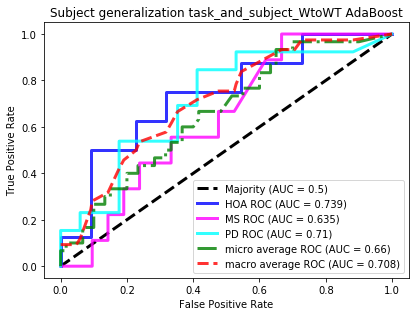

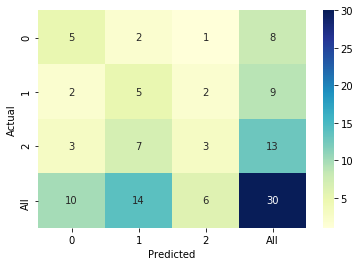

********************************
kernel_svm
best_params:  {'svc__gamma': 0.1}
Stride-based model performance (mean):  [0.366491054866503, 0.49344567696159886, 0.40764871688926824, 0.33606581270366, 0.6505257074183823]
Stride-based model performance (standard deviation):  [0.12708867484438538, 0.13161282521277434, 0.10922985477549182, 0.1432323385044803, 0.08072518432000375]
Person-based model performance (mean):  [0.35952380952380947, 0.4222222222222222, 0.33333333333333337, 0.30126984126984124, 0.6194444444444444]
Person-based model performance (standard deviation):  [0.17535192990020923, 0.12957670877434, 0.31671539586087166, 0.22035588155905192, 0.22815010220423407]


<Figure size 432x288 with 0 Axes>

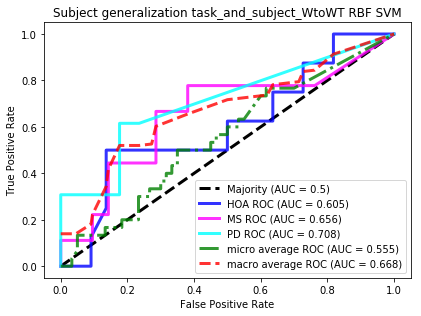

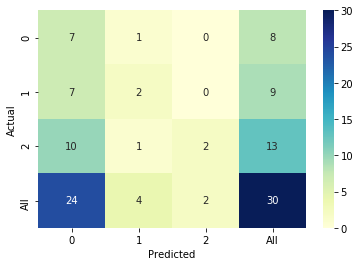

********************************
gbm
best_params:  {'gradientboostingclassifier__learning_rate': 0.15, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__max_features': 'sqrt', 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__n_estimators': 150}
Stride-based model performance (mean):  [0.45327603307201797, 0.49918665228573433, 0.47520048848885893, 0.4398793782489735, 0.666396539626249]
Stride-based model performance (standard deviation):  [0.11477589270940955, 0.10065120646284455, 0.12119389938943705, 0.109983033241731, 0.11182650517170176]
Person-based model performance (mean):  [0.36666666666666664, 0.4111111111111111, 0.34444444444444444, 0.3488888888888889, 0.6916666666666667]
Person-based model performance (standard deviation):  [0.19954596990244725, 0.21256807188565544, 0.2260776661041756, 0.19367785395111933, 0.16583123951776996]


<Figure size 432x288 with 0 Axes>

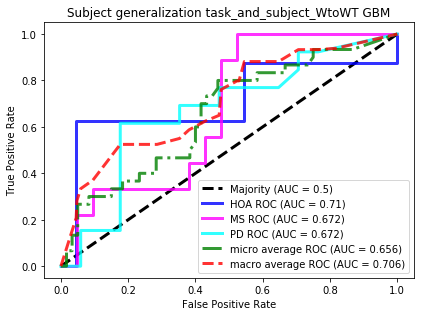

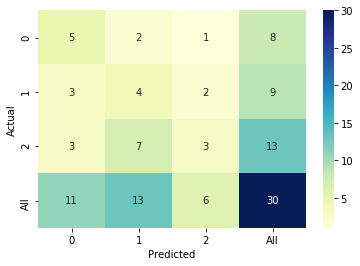

********************************
xgboost
best_params:  {'xgbclassifier__colsample_bytree': 0.6, 'xgbclassifier__gamma': 0.1, 'xgbclassifier__max_depth': 5, 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__subsample': 0.6}
Stride-based model performance (mean):  [0.4349417163813352, 0.47387500326671195, 0.45254378699191705, 0.4202702879446593, 0.6551610521868895]
Stride-based model performance (standard deviation):  [0.1058796469509366, 0.10552482894984742, 0.11450414824498346, 0.10183973631247535, 0.11709839732883924]
Person-based model performance (mean):  [0.3333333333333333, 0.3777777777777777, 0.29999999999999993, 0.3088888888888889, 0.6527777777777779]
Person-based model performance (standard deviation):  [0.18808016817268094, 0.20905430802474198, 0.21256807188565544, 0.17838784213679532, 0.2249828525701843]


<Figure size 432x288 with 0 Axes>

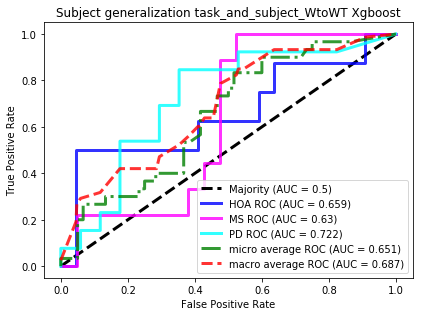

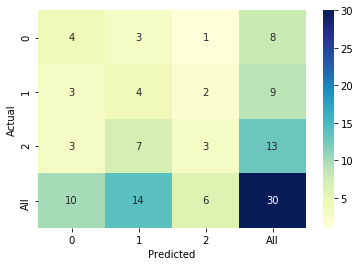

********************************
knn
best_params:  {'kneighborsclassifier__n_neighbors': 1, 'kneighborsclassifier__p': 1}
Stride-based model performance (mean):  [0.43091639607306087, 0.46089061619070765, 0.45602586920841653, 0.41876111071267985, 0.5920194019063124]
Stride-based model performance (standard deviation):  [0.0606803491655444, 0.08062301867301924, 0.06710403629402063, 0.0640424068354406, 0.050328027220515485]
Person-based model performance (mean):  [0.4119047619047619, 0.47777777777777775, 0.38888888888888884, 0.4022222222222222, 0.7472222222222222]
Person-based model performance (standard deviation):  [0.13375782766845845, 0.13877773329774215, 0.16850834320114555, 0.12300757780531596, 0.14656562175858798]


<Figure size 432x288 with 0 Axes>

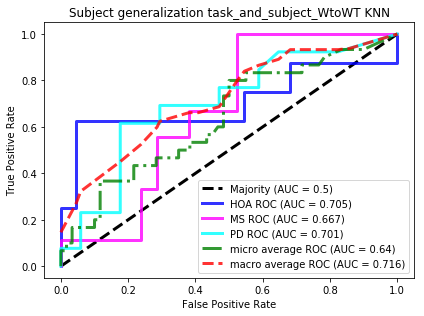

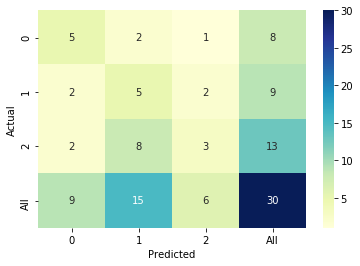

********************************
decision_tree
best_params:  {'decisiontreeclassifier__min_samples_split': 2}
Stride-based model performance (mean):  [0.39536034669181763, 0.42666731395870167, 0.41828901698895005, 0.3831527899551592, 0.5637167627417126]
Stride-based model performance (standard deviation):  [0.05116455269630572, 0.05658993069484514, 0.04329739805526465, 0.05743501256988645, 0.032473048541448474]
Person-based model performance (mean):  [0.35, 0.42222222222222217, 0.2833333333333333, 0.30444444444444446, 0.6555555555555557]
Person-based model performance (standard deviation):  [0.1407785285628046, 0.1143958904554111, 0.20816659994661327, 0.15469603807961882, 0.07827223779780759]


<Figure size 432x288 with 0 Axes>

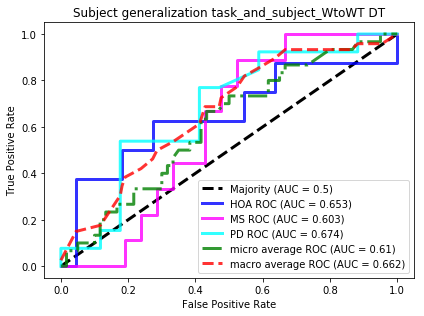

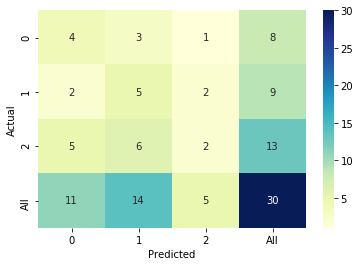

********************************
linear_svm
best_params:  {'svc__gamma': 0.0001}
Stride-based model performance (mean):  [0.446765926775468, 0.4781916826004478, 0.456766808720576, 0.4302759646016316, 0.664982974451501]
Stride-based model performance (standard deviation):  [0.10630543168475945, 0.09787937754608357, 0.11766058751889, 0.10647074300083394, 0.11578093245137205]
Person-based model performance (mean):  [0.3904761904761905, 0.4111111111111111, 0.3444444444444444, 0.35111111111111115, 0.7444444444444445]
Person-based model performance (standard deviation):  [0.24355641623894136, 0.2802115602870776, 0.2519063121945474, 0.2339779455682644, 0.2366171048782984]


<Figure size 432x288 with 0 Axes>

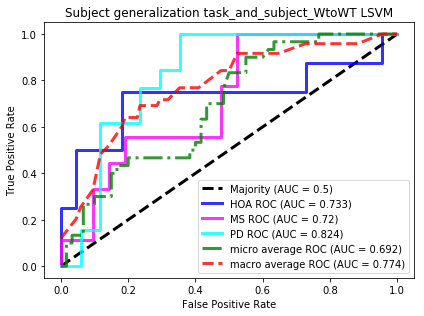

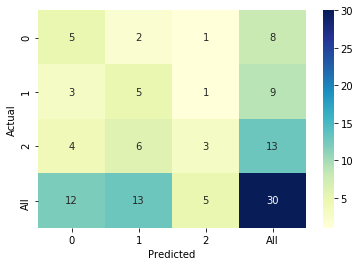

********************************
logistic_regression
best_params:  {'logisticregression__random_state': 0}
Stride-based model performance (mean):  [0.4624793013294443, 0.4842348013296224, 0.47057661896907244, 0.4466052150607941, 0.6697322927584716]
Stride-based model performance (standard deviation):  [0.08713400034779839, 0.08873725351145298, 0.10667758561917702, 0.09490730585968567, 0.09790615428610722]
Person-based model performance (mean):  [0.3952380952380952, 0.44444444444444436, 0.3666666666666666, 0.3733333333333333, 0.7361111111111112]
Person-based model performance (standard deviation):  [0.2159196961667549, 0.25092421756969363, 0.22388268532899872, 0.20663082126414803, 0.21925096956301243]


<Figure size 432x288 with 0 Axes>

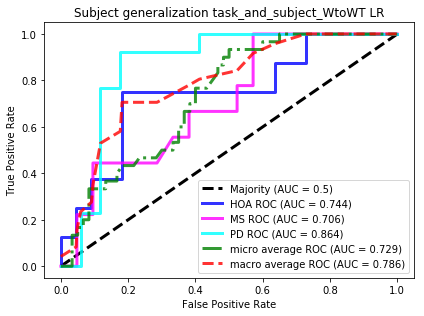

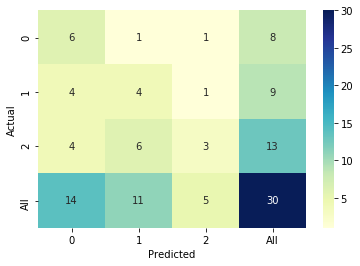

********************************
mlp
best_params:  {'mlpclassifier__hidden_layer_sizes': (5, 5, 5, 5, 10, 100, 20, 100, 30, 5)}
Stride-based model performance (mean):  [0.5252340336050059, 0.49062023290170365, 0.4819644325770257, 0.4705598229909196, 0.6207576950509992]
Stride-based model performance (standard deviation):  [0.048208761910758395, 0.07847473561545283, 0.07619114162858241, 0.0713610184595096, 0.06795181991317538]
Person-based model performance (mean):  [0.5809523809523809, 0.5666666666666667, 0.5555555555555556, 0.5425396825396825, 0.7027777777777777]
Person-based model performance (standard deviation):  [0.2236574964917596, 0.24444444444444446, 0.26057865332352387, 0.24995318281710902, 0.16282612099725385]


<Figure size 432x288 with 0 Axes>

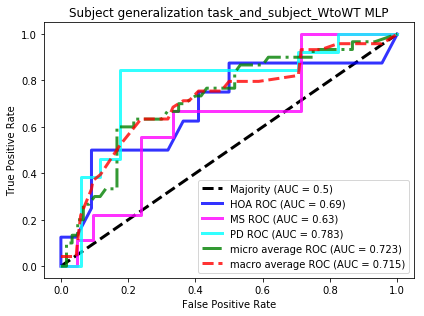

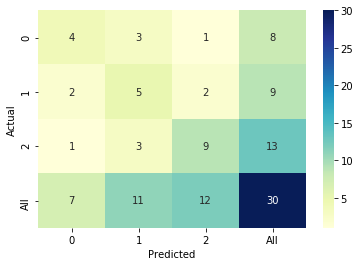

********************************


In [7]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics = run_ml_models(ml_models, X_full, Y_full, train_indices, test_indices, framework, results_path, save_results)

In [8]:
metrics

,random_forest,adaboost,kernel_svm,gbm,xgboost,knn,decision_tree,linear_svm,logistic_regression,mlp
stride_mean_accuracy,0.443386,0.429956,0.366491,0.453276,0.434942,0.430916,0.395360,0.446766,0.462479,0.525234
stride_mean_precision,0.460819,0.455970,0.493446,0.499187,0.473875,0.460891,0.426667,0.478192,0.484235,0.490620
stride_mean_recall,0.459341,0.445236,0.407649,0.475200,0.452544,0.456026,0.418289,0.456767,0.470577,0.481964
stride_mean_F1,0.420556,0.420101,0.336066,0.439879,0.420270,0.418761,0.383153,0.430276,0.446605,0.470560
stride_mean_AUC,0.620269,0.679271,0.650526,0.666397,0.655161,0.592019,0.563717,0.664983,0.669732,0.620758
stride_std_accuracy,0.113043,0.118209,0.127089,0.114776,0.105880,0.060680,0.051165,0.106305,0.087134,0.048209
stride_std_precision,0.093554,0.117586,0.131613,0.100651,0.105525,0.080623,0.056590,0.097879,0.088737,0.078475
stride_std_recall,0.118168,0.118896,0.109230,0.121194,0.114504,0.067104,0.043297,0.117661,0.106678,0.076191
stride_std_F1,0.102446,0.124014,0.143232,0.109983,0.101840,0.064042,0.057435,0.106471,0.094907,0.071361
stride_std_AUC,0.125734,0.086192,0.080725,0.111827,0.117098,0.050328,0.032473,0.115781,0.097906,0.067952


#### Task+subject generalization together framework 2: train on virtual beam walking (VBW) and test on virtual beam walking while talking (VBWT) to classify HOA/MS/PD strides and subjects 

In [13]:
#We are training on some subjects of trial VBW and testing on separate remaining subjects of trial VBWT
train_framework = 'SLW'
test_framework = 'SLWT'

#Extracting the list of PIDs/subjects that are only included in the training set, only included in the testing set 
#and common PIDs in both training and testing sets 
train_pids, test_pids, common_pids = extract_train_test_common_PIDs(data, train_framework, test_framework)
design()


Original number of subjects in training task SLW are: 22
Original number of subjects in testing task SLWT are: 21
Common number of subjects across train and test frameworks:  21
Common subjects across train and test frameworks:  [403, 406, 407, 408, 409, 410, 310, 311, 312, 314, 318, 320, 321, 212, 213, 214, 215, 216, 217, 218, 219]
Number of subjects only in training framework:  1
Subjects only in training framework:  [323]
Number of subjects only in test framework:  0
Subjects only in test framework:  []
******************************************


In [14]:
#Trial VBW for training 
trialVBW = data[data['scenario']==train_framework] #Full trial VBW with all 22 subjects 
#Trial VBWT for testing 
trialVBWT = data[data['scenario']==test_framework] #Full trial VBWT with all 21 subjects 

#Full training data stats 
print ('Number of subjects in trial VBW in each cohort:\n', trialVBW.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete training set: ', len(trialVBW))
print ('HOA, MS and PD strides in complete training set:\n', trialVBW['cohort'].value_counts())
design()

#Full testing data stats 
print ('Number of subjects in trial VBWT in each cohort:\n', trialVBWT.groupby('PID').first()['cohort'].value_counts())
print('Strides in complete testing set: ', len(trialVBWT))
print ('HOA, MS and PD strides in complete testing set:\n', trialVBWT['cohort'].value_counts())
design()

#Training only data with strides from VBW
train_only_trialVBW = trialVBW[trialVBW.PID.isin(train_pids)] #subset of trial W with subjects only present in trial W but not in trial WT
print ('Number of subjects only in trial VBW in each cohort:\n', train_only_trialVBW.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial VBW: ', len(train_only_trialVBW))
print ('HOA, MS and PD strides in of subjects only in trial VBW :\n', train_only_trialVBW['cohort'].value_counts())
design()

#Testing only data with strides from VBWT
test_only_trialVBWT = trialVBWT[trialVBWT.PID.isin(test_pids)] #subset of trial WT with subjects only present in trial WT but not in trial W
print ('Number of subjects only in trial VBWT in each cohort:\n', test_only_trialVBWT.groupby('PID').first()['cohort'].value_counts())
print('Strides of subjects only in trial VBWT: ', len(test_only_trialVBWT))
print ('HOA, MS and PD strides in of subjects only in trial VBWT :\n', test_only_trialVBWT['cohort'].value_counts())
design()

#Training data with strides from VBW for common PIDs in trials VBW and VBWT
train_trialVBW_commonPID = trialVBW[trialVBW.PID.isin(common_pids)] #subset of trial VBW with common subjects in trial VBW and VBWT
print ('Number of subjects common to trials VBW and VBWT in each cohort:\n', train_trialVBW_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial VBW in each cohort of subjects common to trials VBW and VBWT: ', len(train_trialVBW_commonPID))
print ('HOA, MS and PD strides in trial VBW of subjects common to trials VBW and VBWT:\n', train_trialVBW_commonPID['cohort'].value_counts())
design()

#Testing data with strides from VBWT for common PIDs in trials VBW and VBWT
test_trialVBWT_commonPID = trialVBWT[trialVBWT.PID.isin(common_pids)] #subset of trial VBW with common subjects in trial VBW and VBWT
print ('Number of subjects common to trials VBW and VBWT in each cohort:\n', test_trialVBWT_commonPID.groupby('PID').first()['cohort'].value_counts())
print('Strides in trial VBWT in each cohort of subjects common to trials VBW and VBWT: ', len(test_trialVBWT_commonPID))
print ('HOA, MS and PD strides in trial VBWT of subjects common to trials VBW and VBWT:\n', test_trialVBWT_commonPID['cohort'].value_counts())
design()

Number of subjects in trial VBW in each cohort:
 MS     8
HOA    8
PD     6
Name: cohort, dtype: int64
Strides in complete training set:  829
HOA, MS and PD strides in complete training set:
 HOA    336
MS     283
PD     210
Name: cohort, dtype: int64
******************************************
Number of subjects in trial VBWT in each cohort:
 HOA    8
MS     7
PD     6
Name: cohort, dtype: int64
Strides in complete testing set:  837
HOA, MS and PD strides in complete testing set:
 HOA    341
MS     254
PD     242
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial VBW in each cohort:
 MS    1
Name: cohort, dtype: int64
Strides of subjects only in trial VBW:  40
HOA, MS and PD strides in of subjects only in trial VBW :
 MS    40
Name: cohort, dtype: int64
******************************************
Number of subjects only in trial VBWT in each cohort:
 Series([], Name: cohort, dtype: int64)
Strides of subjects only in trial VBWT:  0
HOA,

In [15]:
cols_to_drop = ['key', 'cohort', 'trial', 'scenario', 'video', 'stride_number', 'label', 'PID']
X_train_common_VBWtoVBWT = train_trialVBW_commonPID.drop(cols_to_drop, axis = 1)
Y_train_common_VBWtoVBWT = train_trialVBW_commonPID[['PID', 'label']]

train_test_concatenated_VBWtoVBWT = pd.concat([trialVBW, trialVBWT], axis = 0).reset_index().drop('index', axis = 1)

#Shuffling the concatenated data
train_test_concatenated_VBWtoVBWT = shuffle(train_test_concatenated_VBWtoVBWT, random_state = 0)

#Computing the X (91 features), Y (PID, label) for the models 
X_full_VBWtoVBWT = train_test_concatenated_VBWtoVBWT.drop(cols_to_drop, axis=1)
Y_full_VBWtoVBWT = train_test_concatenated_VBWtoVBWT[['PID', 'label']]
print (X_full_VBWtoVBWT.shape, Y_full_VBWtoVBWT.shape) #1176+1651

#Computing the training and test set indices for the CV folds 
train_indices_VBWtoVBWT, test_indices_VBWtoVBWT = compute_train_test_indices_split(train_test_concatenated_VBWtoVBWT,\
                                                                X_train_common_VBWtoVBWT, Y_train_common_VBWtoVBWT, \
                                                               train_pids, test_pids, train_framework, test_framework)
framework = 'task_and_subject_VBWtoVBWT' #Defining the task generalization framework of interest

(1666, 91) (1666, 2)


random_forest
best_params:  {'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 15, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 0.1, 'randomforestclassifier__n_estimators': 45}
Stride-based model performance (mean):  [0.3888004826694621, 0.3967200932807584, 0.39397958145773715, 0.360131547380841, 0.5503215757070036]
Stride-based model performance (standard deviation):  [0.1049938596274275, 0.11136747263569526, 0.13118336959463228, 0.10715632520505676, 0.152000008932576]
Person-based model performance (mean):  [0.3966666666666666, 0.4, 0.31111111111111106, 0.3266666666666666, 0.6291666666666667]
Person-based model performance (standard deviation):  [0.14313940369055925, 0.1699673171197595, 0.10886621079036347, 0.12244424279071918, 0.21586389744981033]


<Figure size 432x288 with 0 Axes>

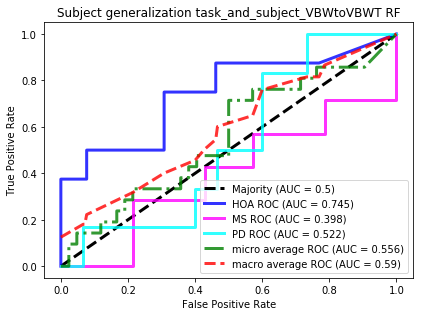

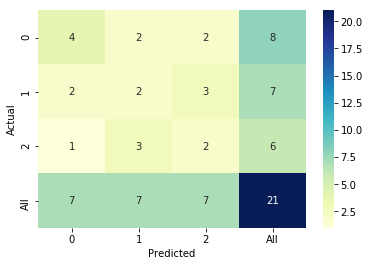

********************************
adaboost
best_params:  {'adaboostclassifier__learning_rate': 1.5, 'adaboostclassifier__n_estimators': 100}
Stride-based model performance (mean):  [0.4028662496911487, 0.40458617883536074, 0.39386402418622846, 0.35463319234781066, 0.540103278244885]
Stride-based model performance (standard deviation):  [0.09734452406347553, 0.10416363368225433, 0.09515963061116908, 0.07840039575286424, 0.0674558712832141]
Person-based model performance (mean):  [0.39666666666666667, 0.3666666666666667, 0.22222222222222224, 0.26666666666666666, 0.5541666666666666]
Person-based model performance (standard deviation):  [0.14313940369055925, 0.1632993161855452, 0.12668615834434865, 0.14298407059684812, 0.18615256586407228]


<Figure size 432x288 with 0 Axes>

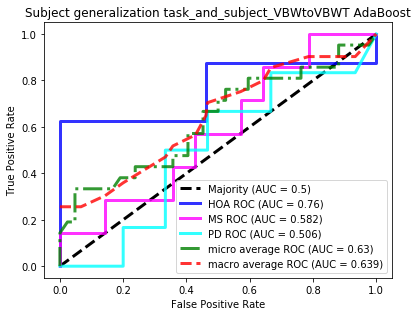

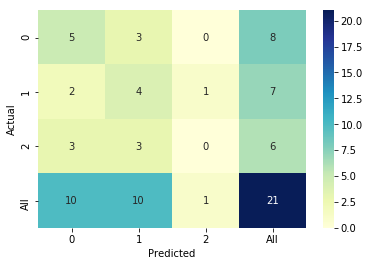

********************************
kernel_svm
best_params:  {'svc__gamma': 1}
Stride-based model performance (mean):  [0.4077725109124157, 0.13592417030413856, 0.3333333333333333, 0.19217184525806558, 0.4438283640456233]
Stride-based model performance (standard deviation):  [0.06296038825287616, 0.02098679608429205, 0.0, 0.020887839916245012, 0.03884069459129874]
Person-based model performance (mean):  [0.38, 0.3333333333333333, 0.12666666666666665, 0.18253968253968253, 0.5]
Person-based model performance (standard deviation):  [0.06531972647421809, 0.0, 0.021773242158072696, 0.02187944246363527, 0.0]


<Figure size 432x288 with 0 Axes>

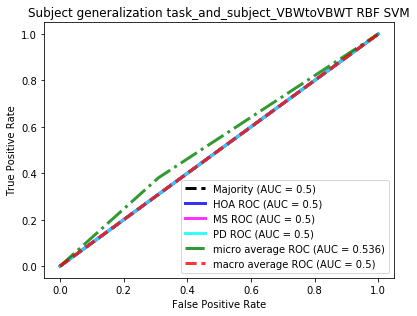

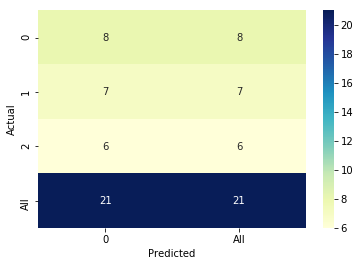

********************************
gbm


In [ ]:
ml_models = ['random_forest', 'adaboost', 'kernel_svm', 'gbm', 'xgboost', 'knn', 'decision_tree',  'linear_svm', 
             'logistic_regression', 'mlp']
metrics_VBWtoVBWT = run_ml_models(ml_models, X_full_VBWtoVBWT, Y_full_VBWtoVBWT, train_indices_VBWtoVBWT, test_indices_VBWtoVBWT,\
                                  framework, results_path, save_results)

In [ ]:
metrics_VBWtoVBWT